# Processamento de Linguagem Natural

Membros do grupo: Beatriz Barreto, Maria Eduarda Bandeira, Yhasmim Tigre.


## Classificando sotaques/regiões brasileiros(as) utilizando versão expandida do dataset de speech MuPe Life storyes.



## Coleta e Preparação dos Dados

### MuPe

#### **Coleta**

*   Utilizamos o dataset de discurso [MuPe Life Stories](https://repositorio.unesp.br/entities/publication/61274d4a-6ac2-487b-a100-8ca5e2974d2c), que consiste em milhares de trechos curtos de áudio de conversas cotidianas. Cada áudio vem acompanhado de uma transcrição gerada pelo modelo [Whisper](https://openai.com/pt-BR/index/whisper/), cujos resultados se mostraram comparáveis à transcrição humana.

*   Devido ao grande volume, os arquivos de áudio foram compactados pelos autores para disponibilização online. Para utilizá-los, foi necessário decodificar o buffer de cada áudio e obter o arquivo original.

#### **Limpeza dos Dados**

*   Removemos registros (áudios) do dataset onde a coluna "estado de nascimento" estava vazia ou continha o valor "unknown" para garantir a utilidade dos dados para o treinamento.


### **SotaTok**

#### **Coleta**

* Para construir esse novo conjunto de dados autoral, realizamos um scraping da plataforma do TikTok utilizando a lib [pytok](https://github.com/networkdynamics/pytok) e filtrando por videos que continham apenas o parâmetro de "audio original", focando no objetivo de pegar o sotaque dos criadores de conteúdo de diferentes estados brasileiros.

#### **Limpeza**

* Para organizar melhos os dados de áudio, cortamos cada audio em segmentos dentro do intervalo de 10 a 30 segundos cada, imitando o estilo de dados do MuPe.

#### **Resultado da Coleta**

* Foram coletados os audios dos estados brasileiros que tinham menos ocorrências no DataFrame do MuPe, para complementar com os dados pré-existentes.

![Unknown-2.png](data: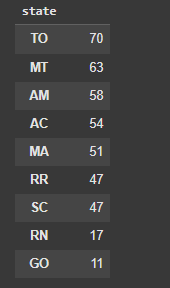

## Arquitetura do Modelo de Classificação de Sotaque/Regionalidade



Este modelo de classificação de sotaque é baseado em um fluxo de trabalho em duas etapas: extração de características e classificação. A arquitetura principal é uma **Rede Neural Densa (ou Fully Connected)**, não um modelo convolucional.

### 1. Entradas dos modelos:

#### 1.1 Entrada de Dados: Do Áudio para um Vetor de Características

* **Entrada:** O modelo recebe um arquivo de áudio.
* **Extração de Características:** Utilizmos a biblioteca `librosa` para extrair múltiplas características de áudio, como **MFCCs**, espectrogramas, croma, e outras características espectrais e temporais.
* **Processamento e Normalização:** Em vez de usar as características em sua forma sequencial, o nosso modelo calcula a **média e o desvio padrão** de cada uma delas. Isso transforma as informações do áudio em um único vetor numérico e plano. Esse vetor é então normalizado usando o `StandardScaler` para que a rede neural possa processá-lo de forma mais eficiente.
* **Sistema de Cache:** O modelo inclui um sistema de cache que salva o vetor de características extraídas em disco. Isso impede que o mesmo arquivo de áudio seja processado várias vezes, otimizando o tempo de execução e o consumo de recursos.

#### 1.2 Entrada de Dados: Do Texto para um Vetor de Características
* **Entrada:** O modelo recebe um texto como entrada, tipicamente uma string.

* **Limpeza e Pré-processamento:** Antes de qualquer vetorização, o texto passa por uma etapa de limpeza, onde é convertido para letras minúsculas e caracteres especiais são removidos. Apenas os caracteres alfanuméricos e acentos são mantidos, o que é essencial para línguas como o português.

* **Extração de Características:** Diferente do áudio, a extração de características em texto se baseia em capturar padrões linguísticos. O modelo utiliza duas abordagens combinadas:

* **Vetorização TF-IDF:** O TfidfVectorizer é aplicado para converter o texto em vetores numéricos. Ele considera a frequência de cada termo no texto e a sua raridade em todo o conjunto de dados. Duas versões do vetorizador são usadas: uma para n-grams de palavras (sequências de 1 a 2 palavras) e outra para n-grams de caracteres (sequências de 2 a 4 caracteres).

* **Características Linguísticas:** O modelo também extrai características adicionais, como o comprimento do texto, o número de palavras, a proporção de vogais e consoantes, e a contagem de pontuação.

* **OBS:** Nesse ponto, o modelo tem três conjuntos de características:

  * Um vetor de características numéricas (densas) das estatísticas linguísticas (comprimento do texto, contagem de palavras, etc.).

  * Uma matriz esparsa de n-grams de palavras.

  * Uma matriz esparsa de n-grams de caracteres.

* **Processamento e Normalização**: O modelo combina todas as características extraídas (os vetores esparsos de TF-IDF e o vetor denso de características linguísticas) em uma única representação. O StandardScaler é usado para normalizar o vetor de características linguísticas. Essa combinação resulta em um vetor único e denso que é a entrada final para a rede neural.

* **Sistema de Cache:** Assim como no modelo de áudio, um sistema de cache salva o vetor de características extraído de cada texto em disco. Isso evita a repetição de processamento de textos já analisados, o que é crucial para conjuntos de dados grandes e economiza tempo.


### 2. Arquitetura dos modelos(Para áudio e para texto respectivamente):
#### 2.1 (Áudio) Rede Neural Densa (Fully Connected)

* **Arquitetura da Rede:** O modelo é uma rede neural sequencial composta por múltiplas camadas densas. Cada camada está totalmente conectada à camada anterior, o que significa que cada neurônio de uma camada recebe entrada de todos os neurônios da camada anterior.
* **Camadas Ocultas:** A rede consiste em **quatro** camadas ocultas com 512, 256, 128 e 64 neurônios, respectivamente. A função de ativação **ReLU** é usada em todas as camadas ocultas.
* **Regularização:** Para evitar o overfitting, a arquitetura incorpora as seguintes técnicas:
    * **Dropout:** Desativa aleatoriamente uma porcentagem de neurônios durante o treinamento, forçando a rede a não depender de neurônios específicos.
    * **Batch Normalization:** Normaliza as ativações das camadas, acelerando o treinamento e melhorando a estabilidade.
    * **Early Stopping:** Interrompendo o treinamento quando não ocorre mudança significativa da loss em 5 épocas.
* **Camada de Saída:** A camada final tem um número de neurônios igual ao número de classes (sotaques) a serem classificadas. A função de ativação **softmax** é usada para produzir uma distribuição de probabilidade, onde a maior probabilidade corresponde à previsão do modelo.

#### 2.2 (Texto) Rede Neural Densa (Fully Connected)
* **Arquitetura da Rede:** O modelo é uma rede neural sequencial composta por múltiplas camadas densas. Cada camada está totalmente conectada à camada anterior, o que significa que cada neurônio de uma camada recebe entrada de todos os neurônios da camada anterior.

* **Camadas Ocultas:** A rede consiste em **quatro** camadas ocultas com 512, 256, 128 e 64 neurônios, respectivamente. A função de ativação **ReLU** é usada em todas as camadas ocultas.

* **Regularização Avançada:** O modelo usa três técnicas de regularização para evitar o overfitting, que é um problema comum em dados de texto com alta dimensionalidade.

* **Dropout:** Desativa neurônios aleatoriamente durante o treinamento para forçar a rede a aprender representações mais robustas.

* **Batch Normalization:** Estabiliza o treinamento e acelera a convergência.

* **Regularização L2:** Adiciona uma penalidade ao valor dos pesos da rede, impedindo que eles cresçam demais e reduzindo a complexidade do modelo.

**Camada de Saída**: A camada final é uma camada densa com a função de ativação softmax para produzir uma distribuição de probabilidade sobre as diferentes classes (sotaques).

### 3. Saída dos modelos

#### Por **estado** ou por **região**

* **Saída:** O modelo retorna uma **string** que é a classificação do sotaque (`birth_state` no código). A rede neural produz um índice numérico (0, 1, 2, ...), que é então convertido de volta para o nome do sotaque original usando o `LabelEncoder`. O modelo também retorna a confiança da previsão, que é a probabilidade da classe prevista.

## Resultados

Os resultados estão separados em duas categorias: áudio e texto. Realizamos os treinos e testes nessas categorias usando apenas o MuPe como entrada, e posteriormente, depois da avaliação desses resultados, adicionamos o SotaTok ao MuPe e geramos um novo resultado. <br/>

Para MuPe, realizamos os seguintes testes:


*   Classificação por Estados - a partir do áudio
*   Classificação por Região - a partir do texto transcrição de áudio

Para MuPe + SoTaTok, realizamos os seguintes testes:


*   Classificação por Estados - a partir do áudio
*   Classificação por Região - a partir do áudio





### MuPe : para áudio ---------------------------------------------------------------------------------------------------------------------


##### RESULTADOS POR ESTADOS - ÁUDIO


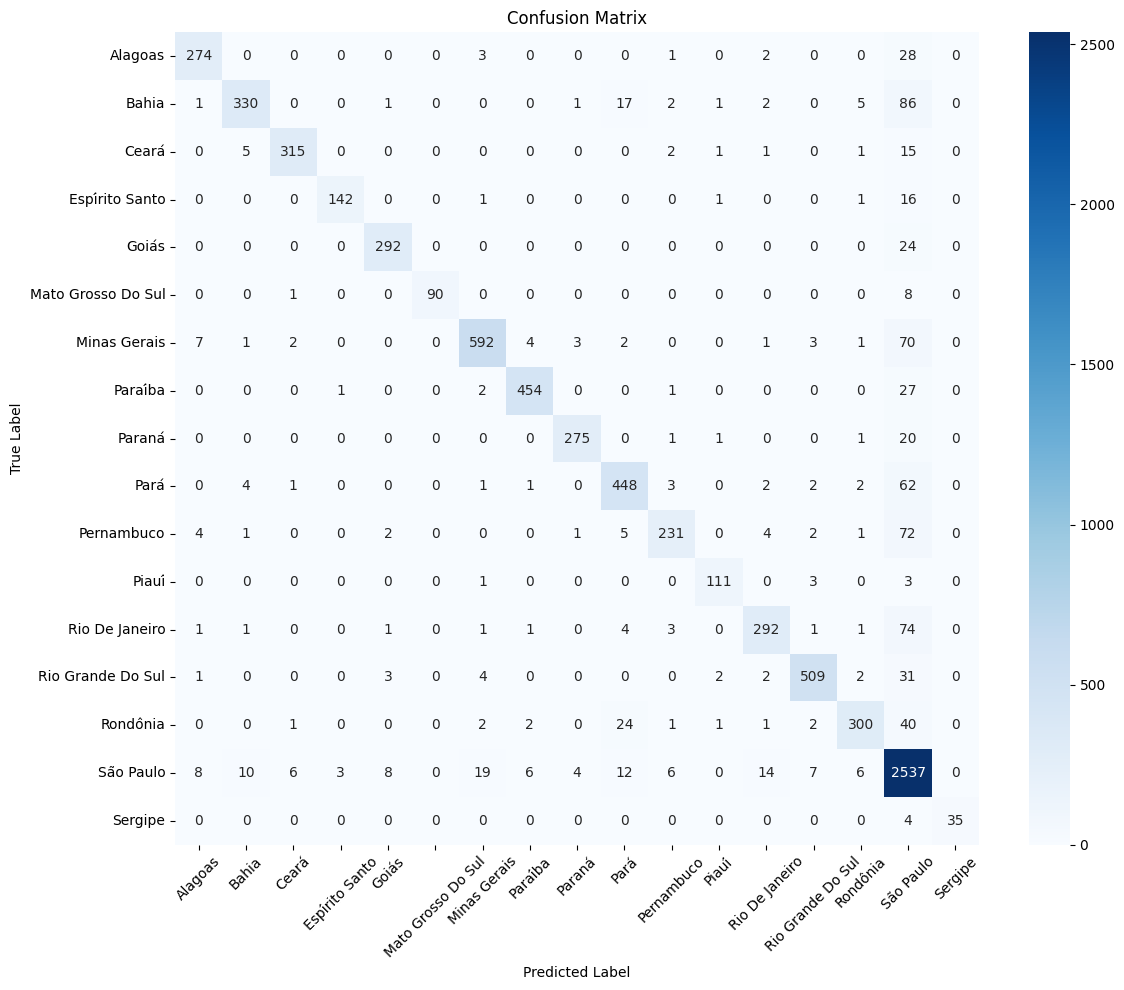

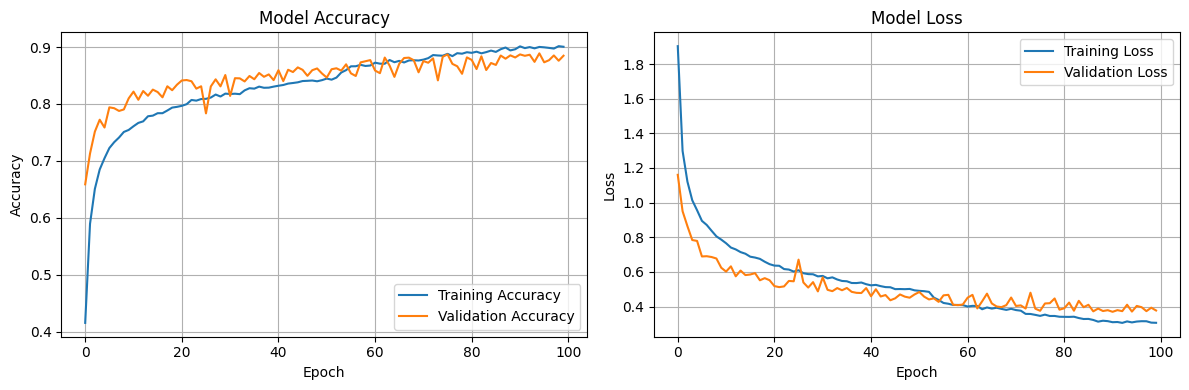

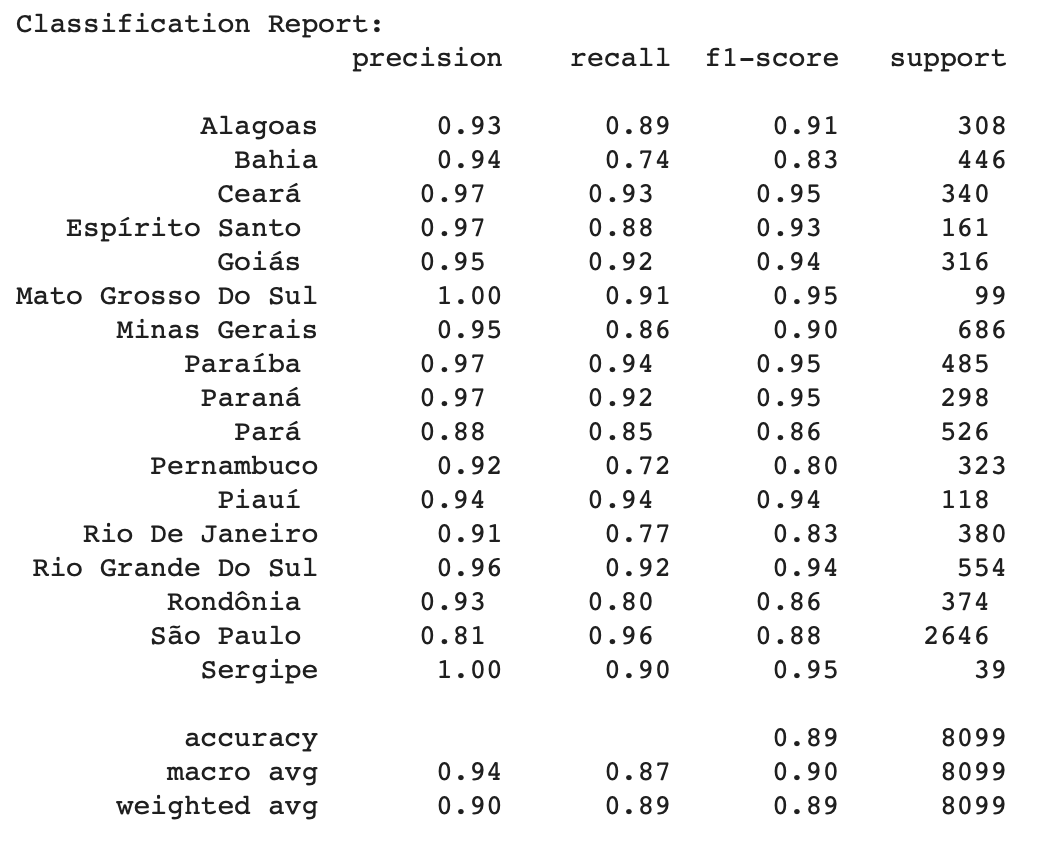

* Acurácia de teste : 89.8%

### MuPe : para texto ---------------------------------------------------------------------------------------------------------------------


##### RESULTADOS POR REGIÃO - TEXTO

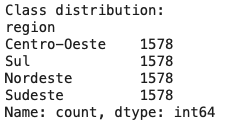

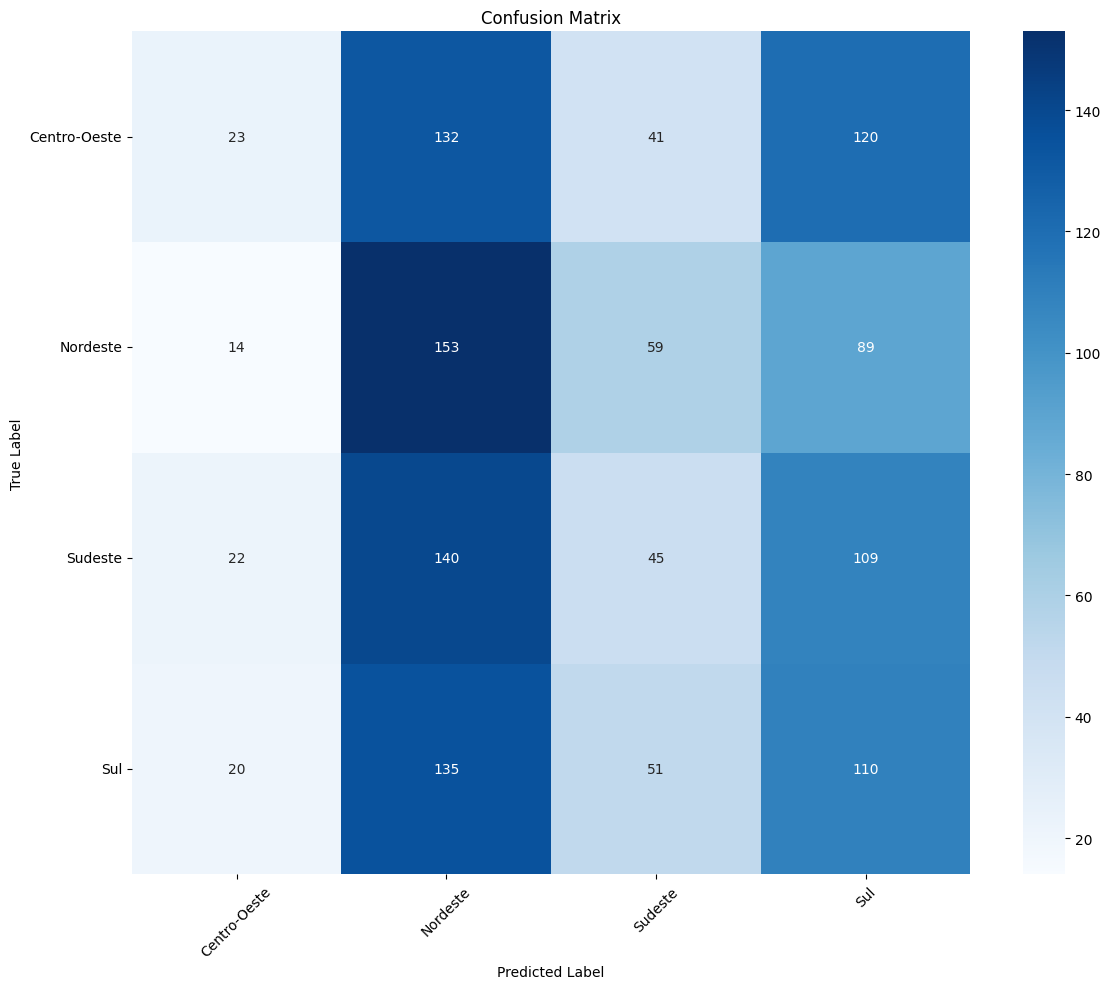

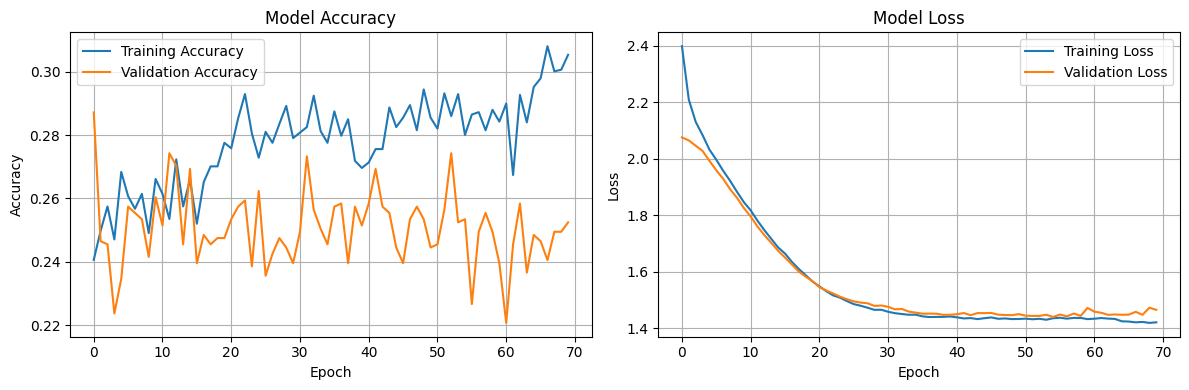

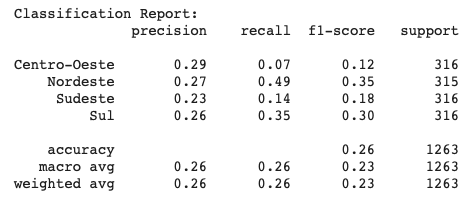

* Acurácia de teste: 26%

Inicialmente, a distribuição de dados por classe (regiões do Brasil) foi equilibrada para que todas as classes possuíssem a mesma quantidade de dados. Porém, pode-se notar na matriz de confusão apresenta um domínio maior para o nordeste. Pensando Nisso, realizamos outro treinamento com -100 dados do nordeste para comparação.

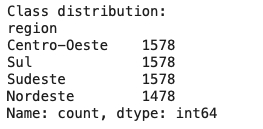

A seguir, alguns testes com frases típicas de algumas regiões foram testadas, para a avaliação do modelo. <br/>
Teste para primeiro teste com dados balanceados:

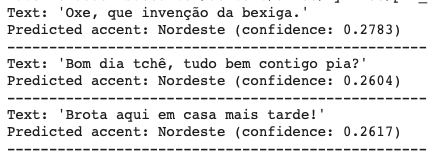

Teste com dados desbalanceados (-100 para Nordeste)

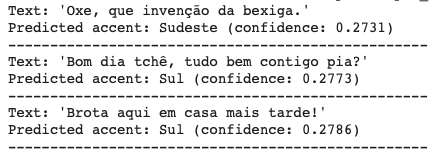

### MuPe + SoTaTok : para áudio ---------------------------------------------------------------------------------------------------------------------


##### RESULTADOS POR ESTADOS - ÁUDIO

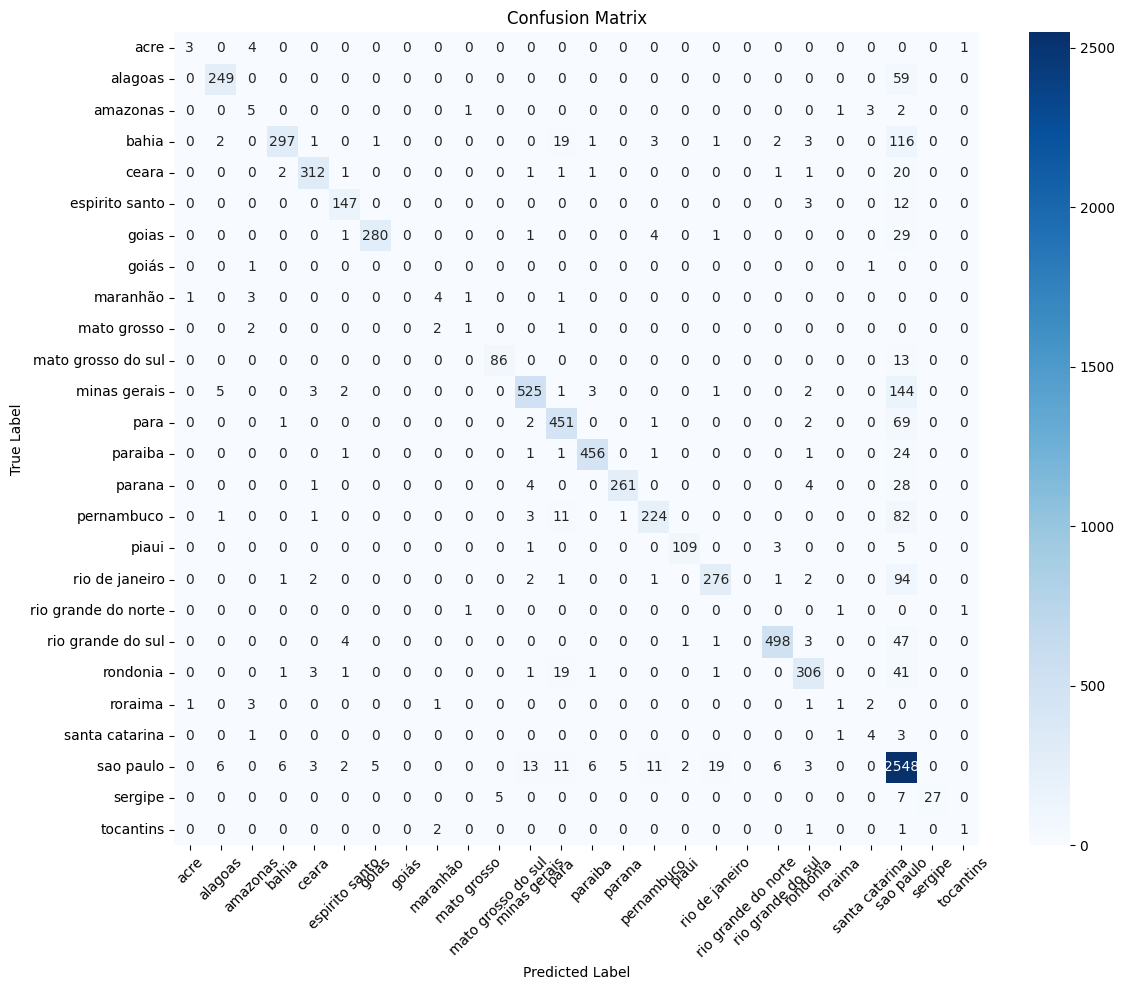

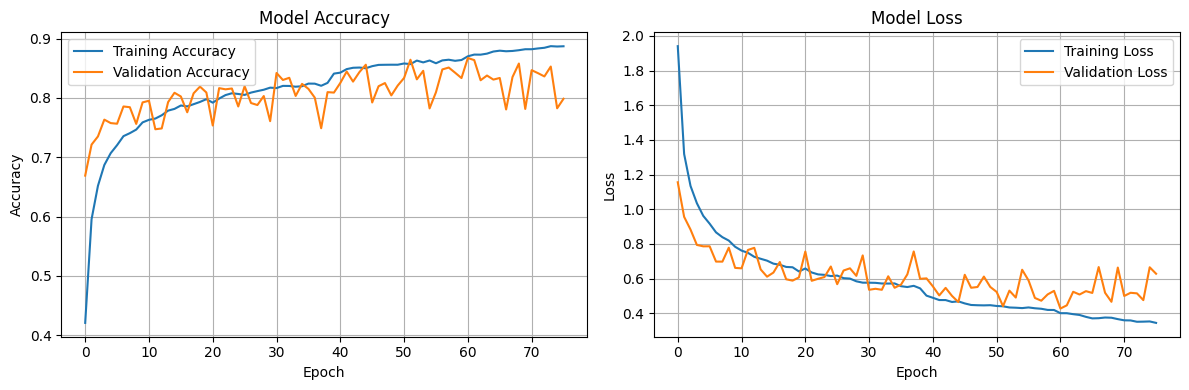

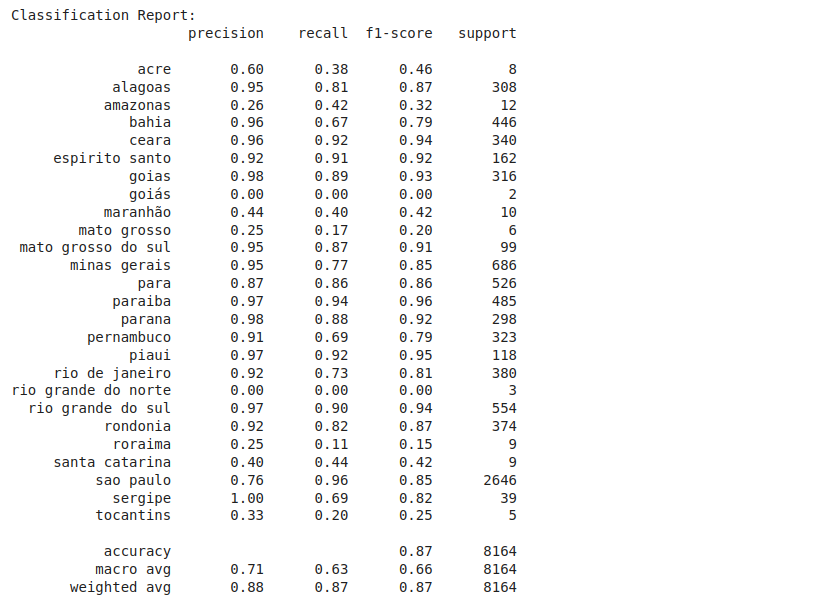

* Acurácia de teste : 86.6%

##### RESULTADOS POR REGIÃO -ÁUDIO

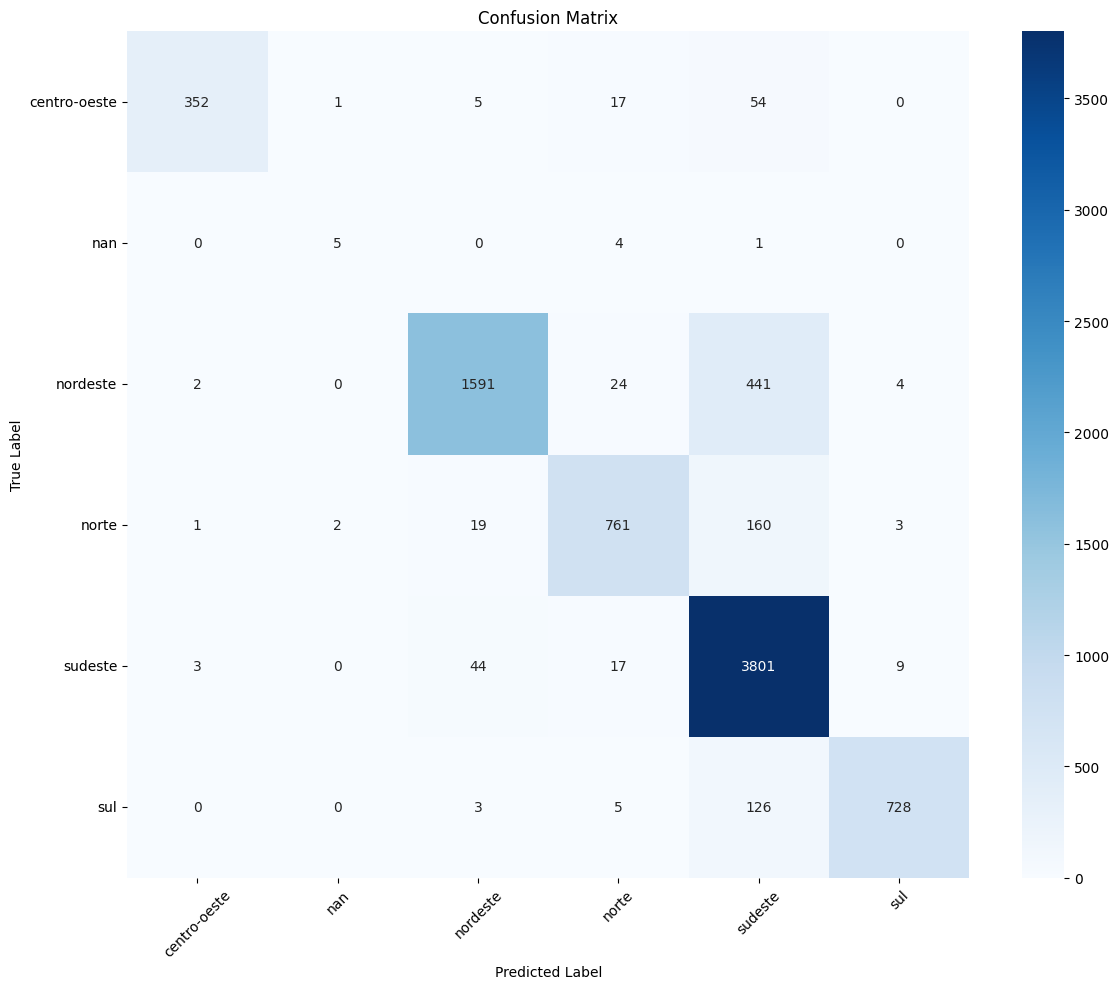

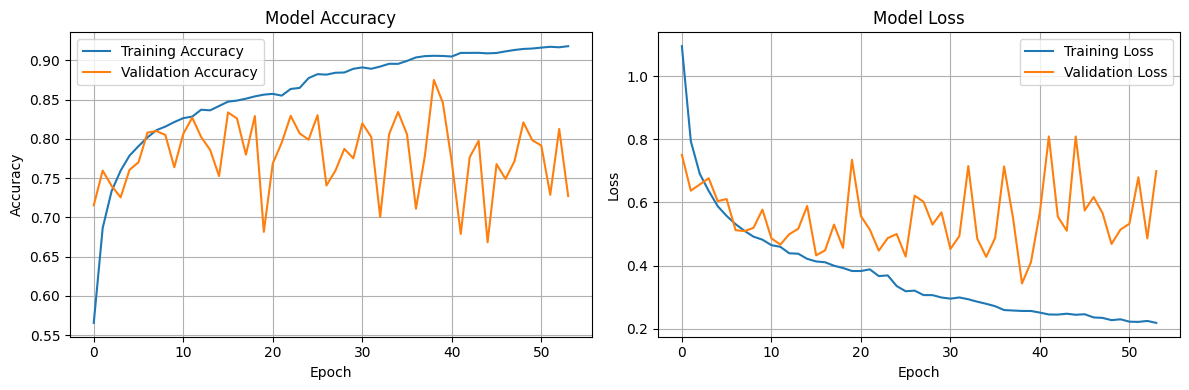

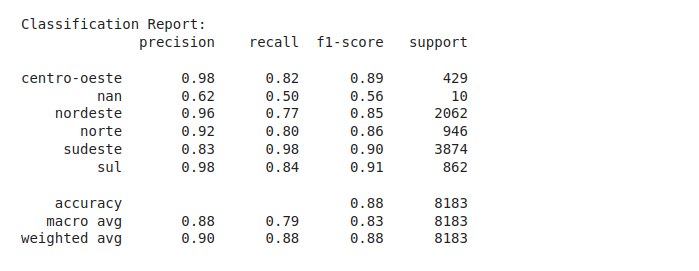

* Acurácia de teste: 88%

## Conclusão

### * Sotaque é um Fenômeno Fonético. A extração de características de áudio(MFCCs) é feita especificamente para analisar o conteúdo fonético de um sinal.
### * Informação(metadados) perdida na escrita. Traços de sotaque simplesmente não têm representação na escrita, restando apenas as expressões regionais(gírias) para o modelo aprender a classificar.
### * A regionalidade dos estados/macrorregiões brasileira em TEXTO não é o suficiente para classificar. O português falado no Brasil tem muitas variações regionais, mas a forma escrita tende a ser muito mais padronizada.
